In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math 

from pyccapt.calibration_tools import tools, data_tools, variables
from pyccapt.mc import mc_tools

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm 
# The initial value for t_0
t0 = 51.74 # ns
variables.init()
save=False

$$\textbf{You can specify which dataset to use in below block}$$

In [2]:
variables.init()

tdc_model = 'surface_concept' # TDC model: surface_concept or roentdec

# dataset name
# dataset_name = 'AL_data_b'
dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'
# dataset_name = 'OLO_Ni_8_data'
# dataset_name = 'X6Cr17_2V30Min_5_data'
# dataset_name = "data_1029_Jun-27-2022_15-53_Pd"


p = path.abspath(path.join("", "../../../../.."))

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/tof_calibratin/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_startCounter = data['dld/start_counter'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [3]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5213.360352,5213.360352,38396.0,630.414792,17.828571,-14.262857
1,5213.360352,5213.360352,38698.0,650.296134,27.093061,19.770612
2,5213.360352,5213.360352,39073.0,647.792964,26.679184,20.248163
3,5213.360352,5213.360352,39830.0,627.609870,8.086531,-10.124082
4,5213.360352,5213.360352,40475.0,3565.145016,-28.334694,-4.075102
...,...,...,...,...,...,...
1900693,5710.761719,5710.761719,39864.0,603.901764,-11.811429,-3.533878
1900694,5710.761719,5710.761719,40013.0,604.951038,-12.989388,-2.451429
1900695,5710.761719,5710.761719,40267.0,619.167672,29.894694,10.442449
1900696,5710.761719,5710.761719,40371.0,605.712276,-12.798367,-0.986939


$\mathbf{\text{calculate the mc in two mode:}}$<br>
$$\frac{m}{n} = k V_{dc}(\frac{t + t_{0}}{d})^{2} $$<br>

$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

In [4]:
# t0
dld_t = dld_t - t0

In [5]:
# Remove negative and zero TOF
threshold = 70
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_pulseVoltage = dld_pulseVoltage[dld_t>threshold]
dld_startCounter = dld_startCounter[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

In [6]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
# y[y>5000] = 0
xaxis = np.arange(len(yaxis))
heatmap, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap[heatmap == 0] = 1  # to have zero after apply log
heatmap = np.log(heatmap)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("hit sequence number", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

# plot high voltage curve
ax2 = ax1.twinx()

# dldGroupStorage[0] --> dld/high_voltage
high_voltage = dld_highVoltage[dld_t < 5000]
xaxis = np.arange(len(high_voltage))
ax2.plot(xaxis, high_voltage, color='r', linewidth=2)
ax2.set_ylabel("DC voltage [V]", color="blue", fontsize=14)
plt.show()

<IPython.core.display.Javascript object>

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

In [7]:
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb_ini[mc_seb_ini < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

<IPython.core.display.Javascript object>

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [27.30531831]
Peaks  0 is: 1.20 peak window sides are: 1.10 - 1.40
Peaks  1 is: 13.86 peak window sides are: 13.56 - 14.16
Peaks  2 is: 27.22 peak window sides are: 26.72 - 27.72


In [9]:
print('################ Before starting the calibration ################')
print('Maximum pick value:', max_hist_ini, 'right-left side of the peak:', left_right_peaks_ini)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))
print('#################################################################')

################ Before starting the calibration ################
Maximum pick value: [27.22075432] right-left side of the peak: [26.72230281 27.71920584]
Mass resolving power (MRP --> m/m_2-m_1): [27.30531831]
Peaks  0 is: 1.20 peak window sides are: 1.10 - 1.40
Peaks  1 is: 13.86 peak window sides are: 13.56 - 14.16
Peaks  2 is: 27.22 peak window sides are: 26.72 - 27.72
#################################################################


<IPython.core.display.Javascript object>


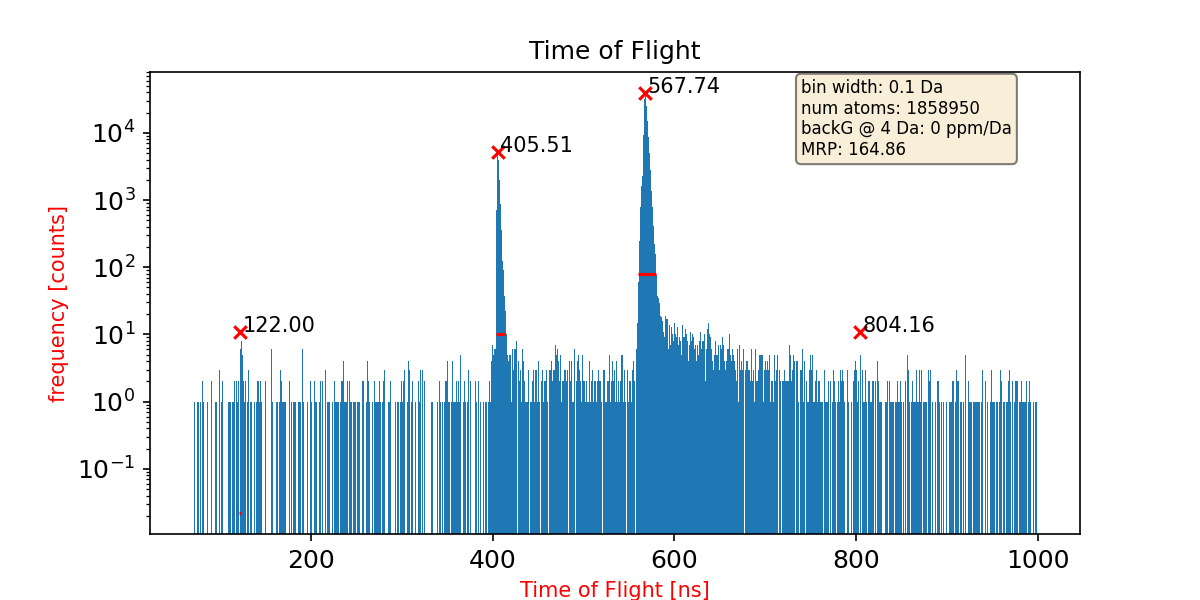

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [164.85853271]
Peaks  0 is: 122.00 peak window sides are: 121.81 - 122.19
Peaks  1 is: 405.51 peak window sides are: 404.49 - 407.09
Peaks  2 is: 567.74 peak window sides are: 566.35 - 569.79
Peaks  3 is: 804.16 peak window sides are: 804.06 - 804.25


In [45]:
max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t[dld_t < 1000], 0.1, distance=1500, percent=50, prominence=8, plot=True, label='tof', fig_name=figname)
mrp = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_tof)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof[i,2], peaks_sides_tof[i,3]))

In [46]:
# fig1, ax1 = plt.subplots(figsize=(8, 4))

# mask_temporal = np.logical_and((max_paek_edges_tof[0] < dld_t), (dld_t < max_paek_edges_tof[1]))

# v_dc = dld_highVoltage[mask_temporal]
# tt = dld_t[mask_temporal]

# x = plt.scatter(v_dc, tt, color="blue", label='t', alpha=0.1)
# ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
# ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
# plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


# flight_distance = np.sqrt(flightPathLength**2 + dld_x[mask_temporal]**2 + dld_y[mask_temporal]**2)

# t_corr = np.sqrt(((flight_distance*1E-3)**2 * np.tile(np.array(26.98), len(dld_highVoltage[mask_temporal]))*1.66E-27)/(2 * 1.6E-19 * dld_highVoltage[mask_temporal]))
# y = plt.scatter(dld_highVoltage[mask_temporal], t_corr*1E9, color="red", label='t_corr', alpha=0.1)


# plt.legend(handles=[x, y], loc='upper right')
# plt.show()

<IPython.core.display.Javascript object>


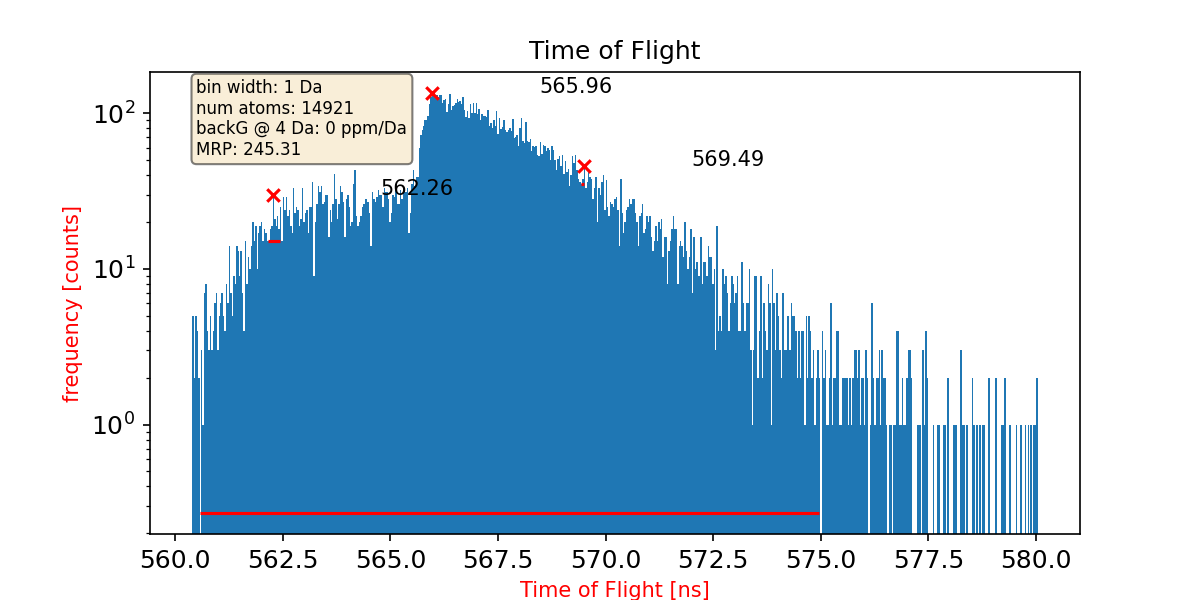

(array([565.95944769]),
 array([565.65409521, 567.96120285]),
 array([[562.26128984,  30.        , 561.88808125, 563.21127534,
          10.        ,   9.        ],
        [565.95944769, 135.        , 565.65409521, 567.96120285,
          60.        ,  62.        ],
        [569.48796527,  46.        , 565.41659883, 569.79331775,
          17.        ,  20.        ]]),
 [560.5648871599104, 574.9503819019538],
 164)

In [47]:
mask_temporal = np.logical_and((max_paek_edges_tof[0] < dld_t), (dld_t < max_paek_edges_tof[1]))

dld_t_peak_v = dld_t[mask_temporal]
dld_x_peak_v = dld_x[mask_temporal]
dld_y_peak_v = dld_y[mask_temporal]
dld_highVoltage_peak_v = dld_highVoltage[mask_temporal]
dld_pulseVoltage_peak_v = dld_pulseVoltage[mask_temporal]



# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 2detector_squre mm * 2detector_squre mm
detector_squre = 2

mask_spacial = np.logical_and((np.abs(dld_x_peak_v) < detector_squre), (np.abs(dld_y_peak_v) < detector_squre))

tools.massSpecPlot(dld_t_peak_v[mask_spacial], 1, distance=100, percent=50, prominence=10, plot=True, label='tof', text_loc='left', fig_name='peak_'+figname)

<IPython.core.display.Javascript object>


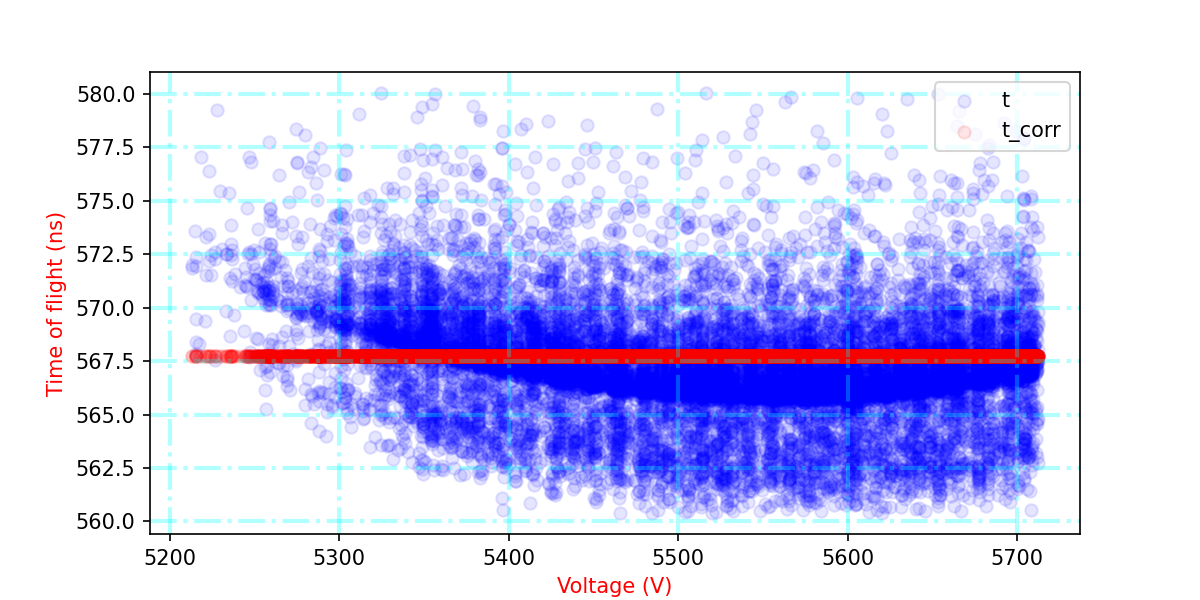

In [48]:
fig1, ax1 = plt.subplots(figsize=(8, 4))


x = plt.scatter(dld_highVoltage_peak_v[mask_spacial], dld_t_peak_v[mask_spacial], color="blue", label='t', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


# flight_distance = np.sqrt((flightPathLength*1E-3)**2 + (dld_x_peak_v[mask_spacial]*1E-3)**2 + (dld_y_peak_v[mask_spacial]*1E-3)**2)
# t_corr = np.sqrt((((flight_distance)**2) * np.tile(max_hist_ini, len(dld_highVoltage_peak_v[mask_spacial]))*1.66E-27)/(2 * 1.6E-19 * dld_highVoltage_peak_v[mask_spacial]))
t_corr = np.tile(max_hist_tof, len(dld_highVoltage_peak_v[mask_spacial])) * 1E-9

y = plt.scatter(dld_highVoltage_peak_v[mask_spacial], t_corr*1E9, color="red", label='t_corr', alpha=0.1)


plt.legend(handles=[x, y], loc='upper right')
if save==True:
    plt.savefig(variables.result_path + "//peak_tof_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//peak_tof_corr_%s.png" % figname, format="png", dpi=600)
plt.show()


In [49]:
def voltage_corr(x, a, b, c, d):
#     return a / np.sqrt((b + (c * x) + (d * (x**2))))
   return (a / (b * (x ** 2) + c * x + d))
#    return (a / (b * x**2))

def voltage_corection(highVoltage, t):
    fitresult, _ = curve_fit(voltage_corr, highVoltage, t)
    return fitresult


# scaler = MinMaxScaler(feature_range=(0, 1))
# dld_highVoltage_peak_norm = scaler.fit_transform(dld_highVoltage_peak_v[mask_spacial].reshape(-1, 1)).reshape((-1,)) 
# t_norm = (t_corr*1E9)/(dld_t_peak_v[mask_spacial])
# target_peak_v_norm = scaler.fit_transform(t_norm.reshape(-1, 1)).reshape((-1,)) 

# fitresult = voltage_corection(dld_highVoltage_peak_norm, (target_peak_v_norm))


# dld_highVoltage_norm = scaler.fit_transform(dld_highVoltage.reshape(-1, 1)).reshape((-1,)) 

mask = np.random.randint(0, len(dld_highVoltage_peak_v[mask_spacial]), 100)
input_1 = dld_highVoltage_peak_v[mask_spacial]
output_1 = max_hist_tof / dld_t_peak_v[mask_spacial]
fitresult = voltage_corection(input_1[mask], output_1[mask] )




f_v = voltage_corr(dld_highVoltage, *fitresult)


<IPython.core.display.Javascript object>


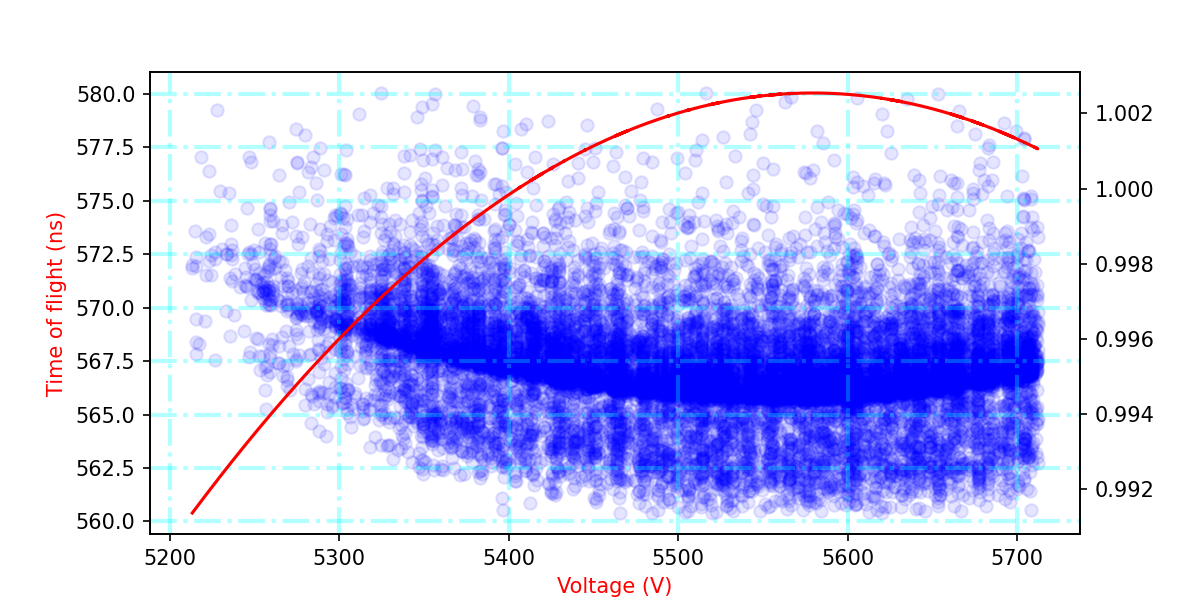

In [50]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

x = plt.scatter(dld_highVoltage_peak_v[mask_spacial], ((dld_t_peak_v[mask_spacial])), color="blue", label='t', alpha=0.1)
# y = plt.scatter(dld_highVoltage_peak_v[mask_spacial], (aaa), color="blue", label='t', alpha=0.1)
# x = plt.scatter(VDC, corr, color="blue", label='t', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

# plot high voltage curve
ax2 = ax1.twinx()
y = ax2.plot(dld_highVoltage_peak_v[mask_spacial], voltage_corr(dld_highVoltage_peak_v[mask_spacial], *fitresult), color='r', label='F_V')
# y = ax2.plot(VDC, voltage_corr(VDC, *fitresult), color='r', label='F_V')

# plt.legend(handles=[x, y], loc='upper right')

if save==True:
    plt.savefig(variables.result_path + "//vol_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//vol_corr_%s.png" % figname, format="png", dpi=600)
    
plt.show()

In [51]:
dld_t_new_v = dld_t * f_v

<IPython.core.display.Javascript object>


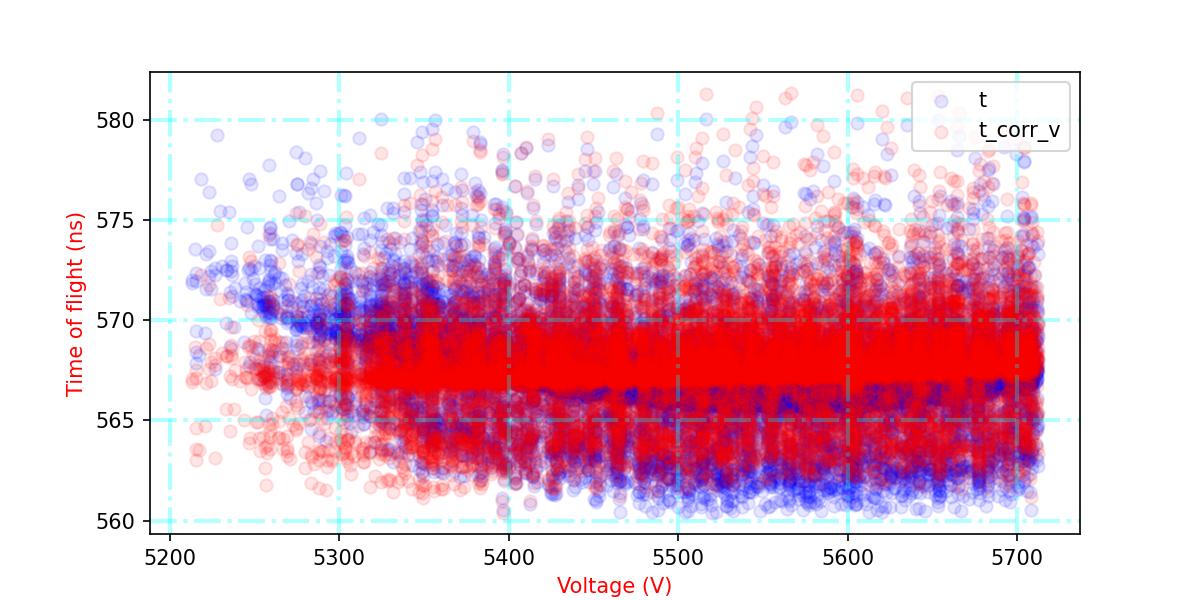

In [52]:
fig1, ax1 = plt.subplots(figsize=(8, 4))




x = plt.scatter(dld_highVoltage_peak_v[mask_spacial], dld_t_peak_v[mask_spacial], color="blue", label='t', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


dld_t_plot = dld_t_new_v[mask_temporal]

y = plt.scatter(dld_highVoltage_peak_v[mask_spacial], dld_t_plot[mask_spacial], color="red", label='t_corr_v', alpha=0.1)


plt.legend(handles=[x, y], loc='upper right')
if save==True:
    plt.savefig(variables.result_path + "//peak_tof_V_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//peak_tof_V_corr_%s.png" % figname, format="png", dpi=600)
plt.show()

<IPython.core.display.Javascript object>


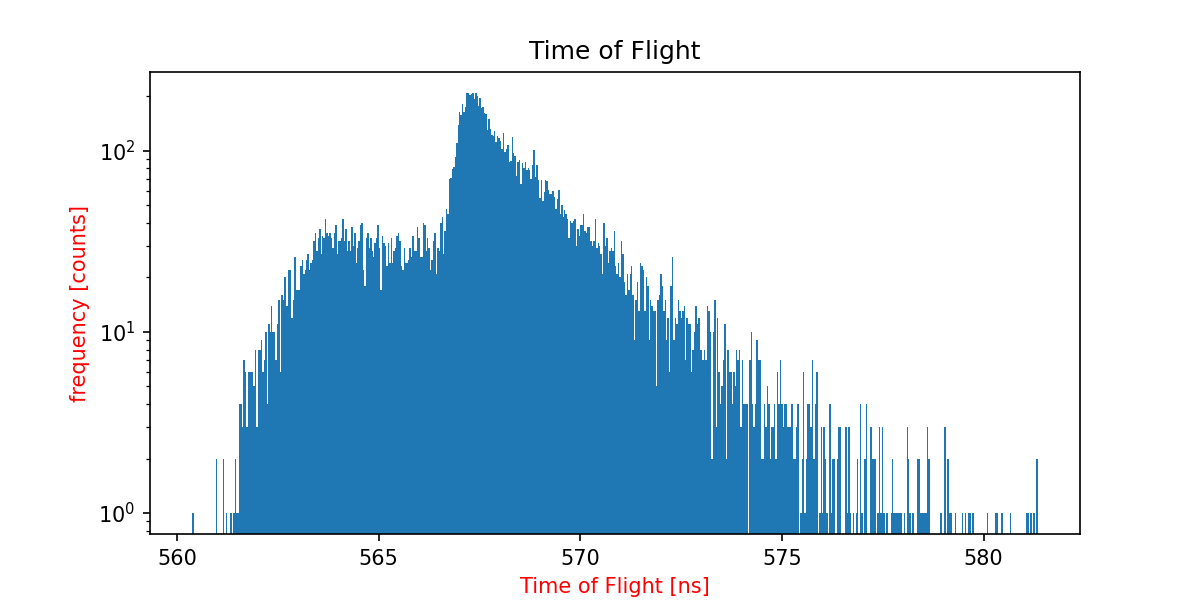

(0, 0, 0, 0, 0)

In [53]:
dld_t_plot = dld_t_new_v[mask_temporal]
tools.massSpecPlot(dld_t_plot[mask_spacial], 1, distance=100, percent=50, prominence=10, plot=True, peaks_find=False, label='tof', text_loc='left', fig_name='peak_'+figname)

<IPython.core.display.Javascript object>


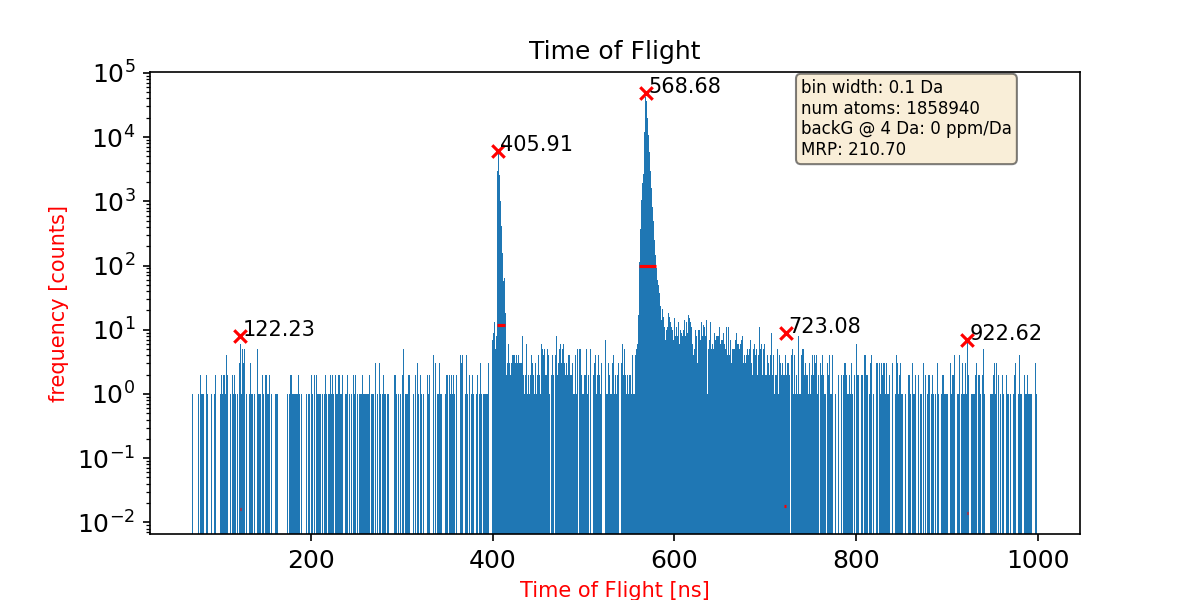

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [210.70275857]
Peaks  0 is: 122.23 peak window sides are: 121.77 - 122.70
Peaks  1 is: 405.91 peak window sides are: 405.16 - 407.40
Peaks  2 is: 568.68 peak window sides are: 567.38 - 570.08
Peaks  3 is: 723.08 peak window sides are: 722.90 - 723.18
Peaks  4 is: 922.62 peak window sides are: 922.53 - 922.72


In [54]:
max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t_new_v[dld_t_new_v < 1000], 0.1, distance=1500, prominence=4, percent=50, plot=True, label='tof', fig_name='V_'+figname)
mrp = (max_hist_tof_v / (left_right_peaks_tof_v[1] - left_right_peaks_tof_v[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_tof_v)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof_v[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof_v[i,2], peaks_sides_tof_v[i,3]))

In [55]:
mask_temporal_bowl = np.logical_and((max_paek_edges_tof_v[0] < dld_t_new_v), (dld_t_new_v < max_hist_tof_v + (max_hist_tof_v -max_paek_edges_tof_v[0])))
dld_t_peak_bowl = dld_t_new_v[mask_temporal_bowl]
dld_x_peak_bowl = dld_x[mask_temporal_bowl]
dld_y_peak_bowl = dld_y[mask_temporal_bowl]
dld_highVoltage_peak_bowl = dld_highVoltage[mask_temporal_bowl]
dld_pulseVoltage_peak_bowl = dld_pulseVoltage[mask_temporal_bowl]

<IPython.core.display.Javascript object>


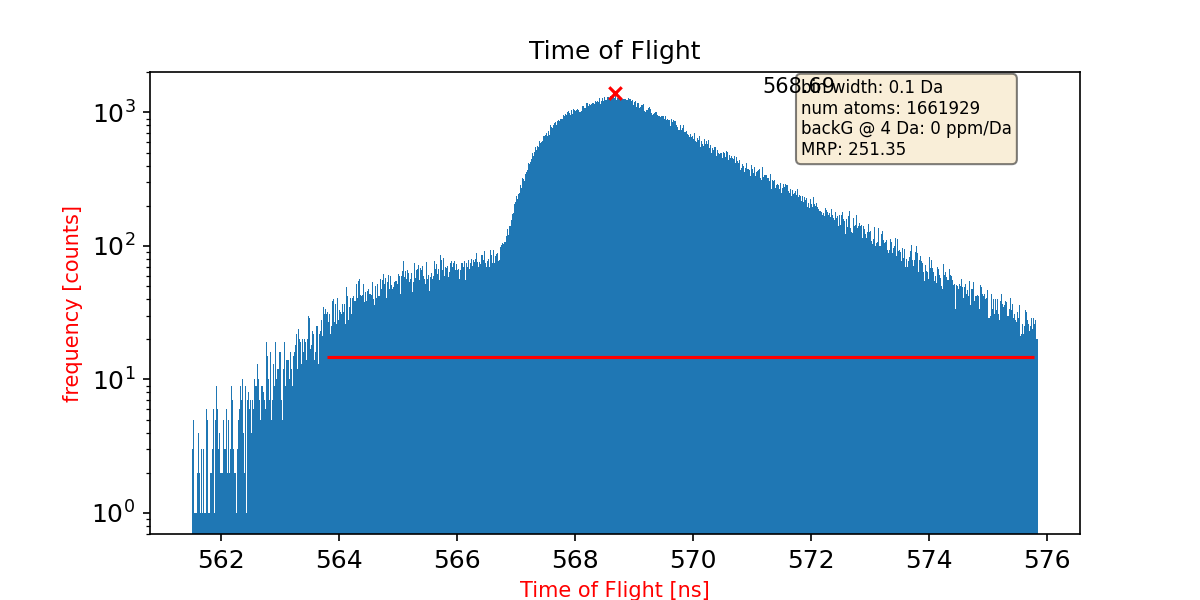

(array([568.68858118]),
 array([567.57350546, 569.83601401]),
 array([[ 568.68858118, 1399.        ,  567.57350546,  569.83601401,
          683.        ,  699.        ]]),
 [563.802657873869, 575.7847438617598],
 2880)

In [56]:

vol = 5500
# mask_bowl = np.logical_and((vol - 20 < dld_highVoltage_peak_bowl), (dld_highVoltage_peak_bowl < vol + 20))
mask_bowl = np.logical_and((dld_highVoltage_peak_bowl), (dld_highVoltage_peak_bowl))
# mask_bowl[mask_bowl==True].shape

dld_highVoltage_bowl = dld_highVoltage_peak_bowl[mask_bowl]
dld_pulseVoltage_bowl = dld_pulseVoltage_peak_bowl[mask_bowl]
dld_x_bowl = dld_x_peak_bowl[mask_bowl]
dld_y_bowl = dld_y_peak_bowl[mask_bowl] 
dld_t_bowl = dld_t_peak_bowl[mask_bowl]

# dld_t_new_v_bowl = dld_t_new_v[mask_temporal_bowl]
# dld_t_bowl = dld_t_new_v_bowl[mask_bowl]

tools.massSpecPlot(dld_t_bowl, 0.1, distance=1000, percent=50, prominence=100, plot=True, label='tof', fig_name='bowl_pre_corr_'+figname)

In [57]:
def bowl_corr_fit(data_xy, a, b, c, d, e, f):
    x = data_xy[0]
    y = data_xy[1]
#     result = np.sqrt(a + b*x + c*y + d*(x**2) + e*x*y + f*(y**2))
    result = (a + b*x + c*y + d*(x**2) + e*x*y + f*(y**2))
    return result
def bowl_correction(dld_x, dld_y, dld_t):

    parameters, covariance = curve_fit(bowl_corr_fit, [dld_x, dld_y],  dld_t)
    return parameters

scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
x_bowl = scaler2.fit_transform(dld_x_bowl.reshape(-1, 1)).reshape((-1,)) 
y_bowl = scaler2.fit_transform(dld_y_bowl.reshape(-1, 1)).reshape((-1,)) 
target_bowl = max_hist_tof_v / dld_t_bowl
# target_bowl = scaler1.fit_transform(target_bowl.reshape(-1, 1)).reshape((-1,)) 
parameters = bowl_correction(x_bowl, y_bowl, target_bowl)

dld_x_norm = scaler2.fit_transform(dld_x.reshape(-1, 1)).reshape((-1,)) 
dld_y_norm = scaler2.fit_transform(dld_y.reshape(-1, 1)).reshape((-1,)) 
f_bowl = bowl_corr_fit([dld_x_norm,dld_y_norm], *parameters)
# f_bowl =  f_bowl / max_hist_tof_v

# parameters = bowl_correction(dld_x_bowl, dld_y_bowl, max_hist_tof_v/dld_t_bowl)
# f_bowl = bowl_corr_fit([dld_x,dld_y], *parameters)
# f_bowl = max_hist_tof_v / f_bowl


In [58]:
dld_t_new_bowl = dld_t_new_v * f_bowl

<IPython.core.display.Javascript object>


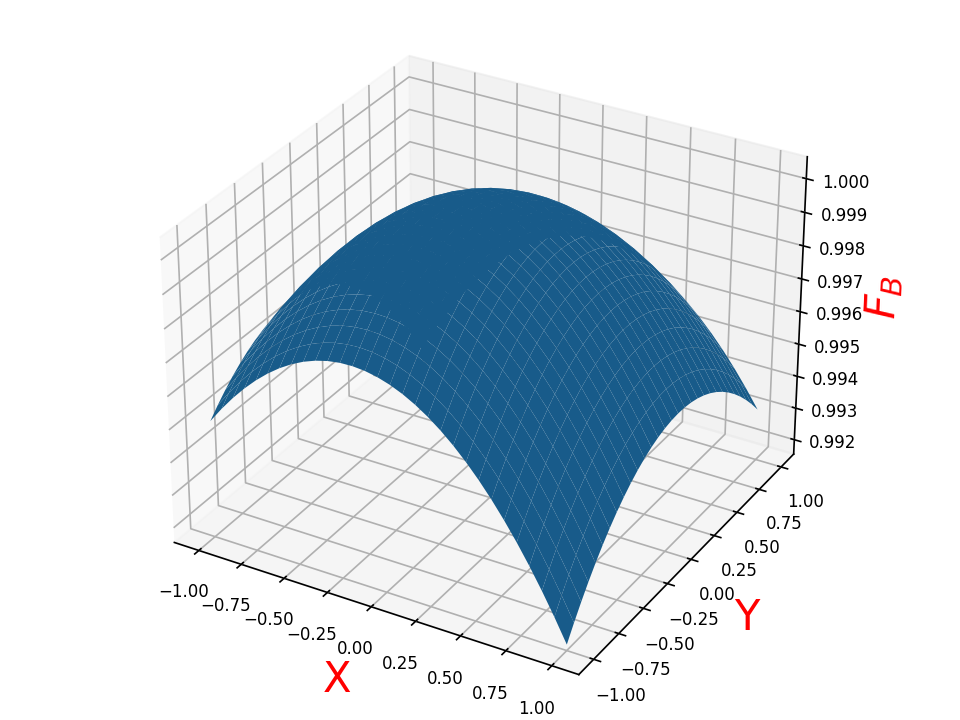

In [59]:
# create surface function model
# setup data points for calculating surface model
# model_x_data = np.linspace(min(dld_x_bowl), max(dld_x_bowl), 30)
# model_y_data = np.linspace(min(dld_y_bowl), max(dld_y_bowl), 30)
model_x_data = np.linspace(-1, 1, 30)
model_y_data = np.linspace(-1, 1, 30)
# create coordinate arrays for vectorized evaluations
X, Y = np.meshgrid(model_x_data, model_y_data)
# calculate Z coordinate array
Z = bowl_corr_fit(np.array([X, Y]), *parameters)

# setup figure object
fig = plt.figure()
# setup 3d object
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
# plot surface
ax.plot_surface(X, Y, Z)
# plot input data
# ax.scatter(detxIn, detyIn, mcIn, color='red')
# set plot descriptions
ax.set_xlabel('X', color="red", fontsize=20)
ax.set_ylabel('Y', color="red", fontsize=20)
ax.set_zlabel(r"$F_B$", color="red", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.tick_params(axis='both', which='minor', labelsize=8)

if save==True:
    plt.savefig(variables.result_path + "//bowl_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//bowl_corr_%s.png" % figname, format="png", dpi=600)

plt.show()

<IPython.core.display.Javascript object>


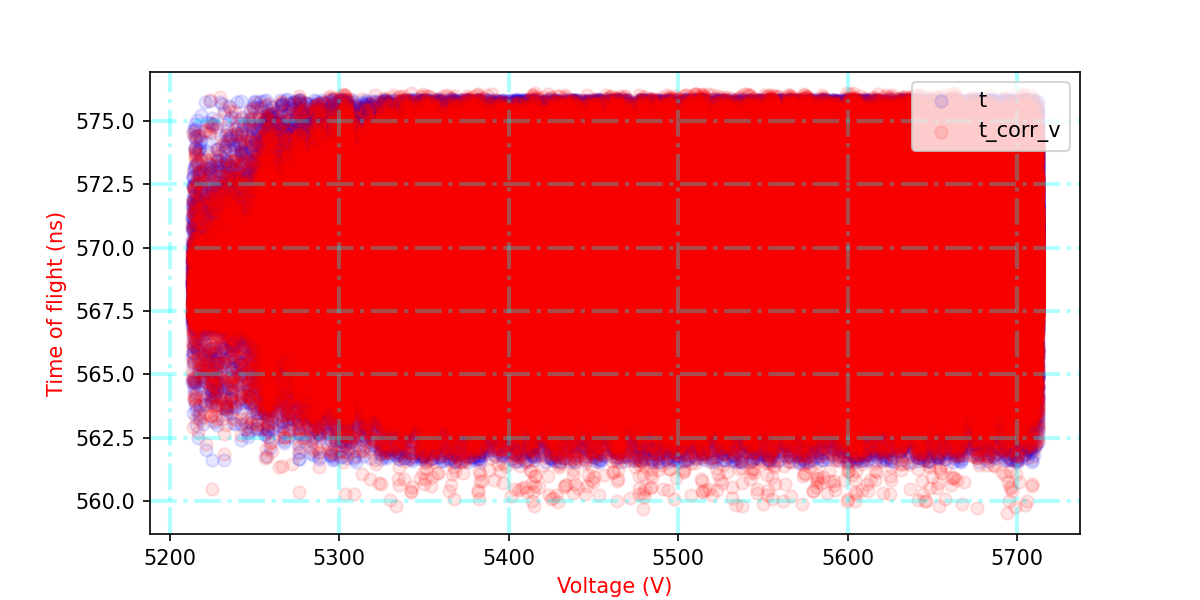

In [60]:
fig1, ax1 = plt.subplots(figsize=(8, 4))


x = plt.scatter(dld_highVoltage_peak_bowl[mask_bowl], dld_t_peak_bowl[mask_bowl], color="blue", label='t', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("Voltage (V)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)


dld_t_plot = dld_t_new_bowl[mask_temporal_bowl]
# dld_t_plot = dld_t_new_bowl[mask_temporal_bowl]

y = plt.scatter(dld_highVoltage_peak_bowl[mask_bowl], dld_t_plot[mask_bowl], color="red", label='t_corr_v', alpha=0.1)


plt.legend(handles=[x, y], loc='upper right')

if save==True:
    plt.savefig(variables.result_path + "//peak_tof_bowl_corr_%s.svg" % figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + "//peak_tof_bowl_corr_%s.png" % figname, format="png", dpi=600)
plt.show()


<IPython.core.display.Javascript object>


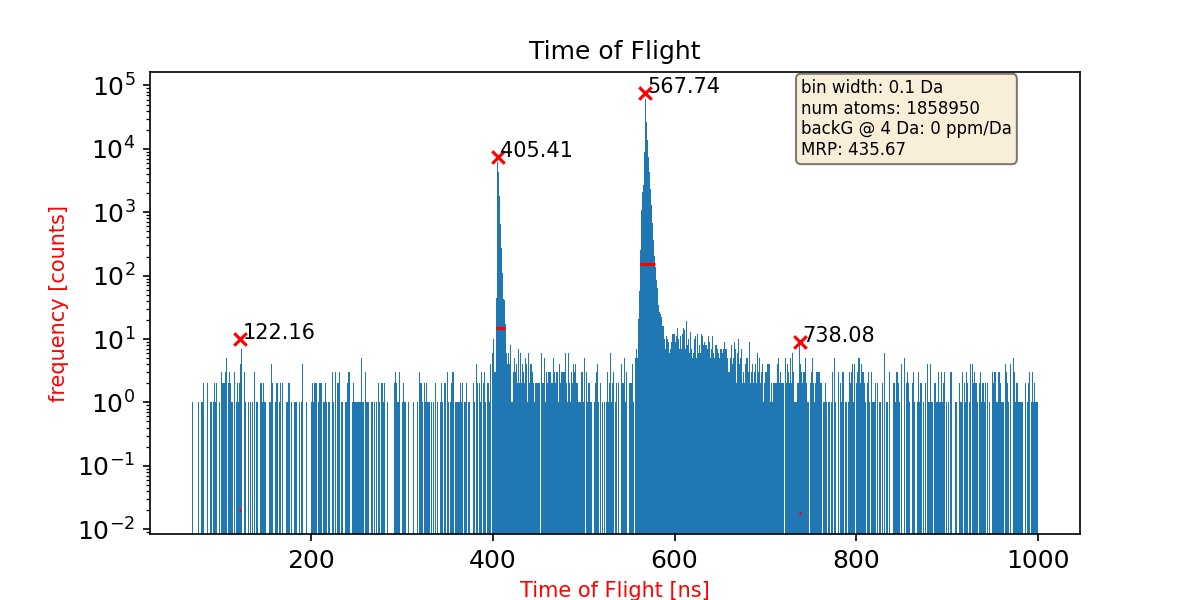

In [61]:
max_hist_tof_bowl, left_right_peaks_tof_bowl, peaks_sides_tof_bowl, max_paek_edges_tof_bowl, index_max_tof_bowl = tools.massSpecPlot(dld_t_new_bowl[dld_t_new_bowl < 1000], 0.1, distance=1500, prominence=8, percent=50, plot=True, label='tof', fig_name='bowl_'+figname)

In [62]:
dld_t = dld_t_new_bowl

In [63]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult


dld_t_peak_p = [122.16, 505.41, 567.74]
mc_ideal = [1, 13.49, 26.98]
fitresult = parametric_calib(dld_t_peak_p, mc_ideal)


mc_p = parametric(dld_t, *fitresult)

C:\Users\mehrp\.conda\envs\apt\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


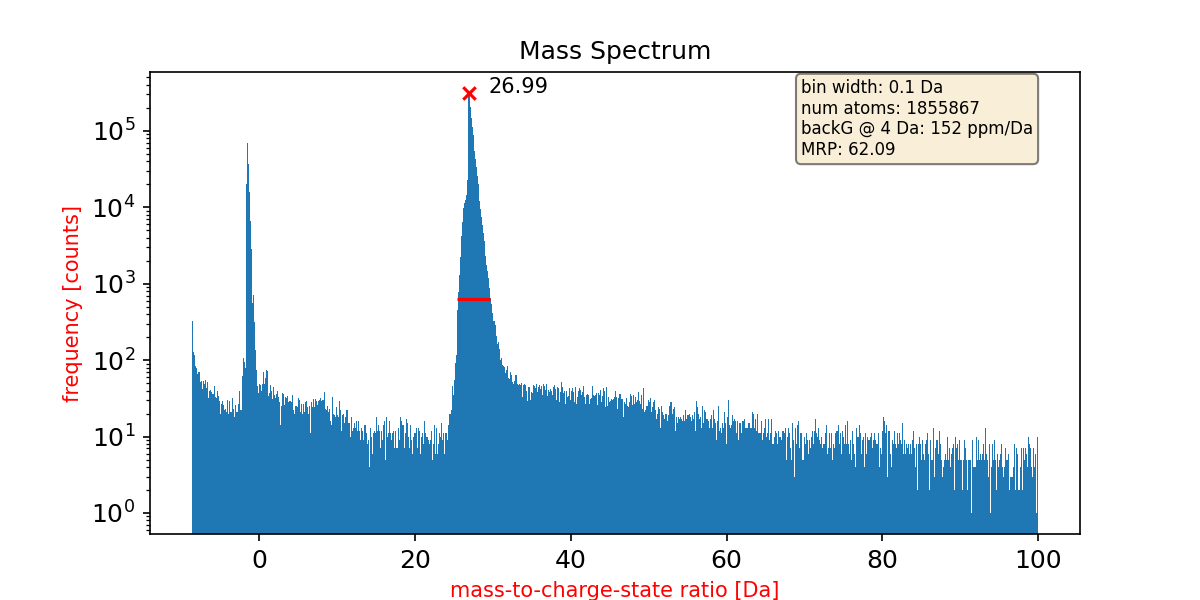

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [62.0855742]
Peaks  0 is: 26.99 peak window sides are: 26.77 - 27.21


In [64]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p[mc_p < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='bowl_'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [65]:
dld_t_peak_p = [122.16, 505.41, 567.74]
mc_ideal = [1, 13.49, 26.98]

delta_t = interpolate.interp1d(dld_t_peak_p, mc_ideal, kind='linear', fill_value="extrapolate")
delta_t_m = delta_t(dld_t)  
mc_p_2 = delta_t_m

<IPython.core.display.Javascript object>


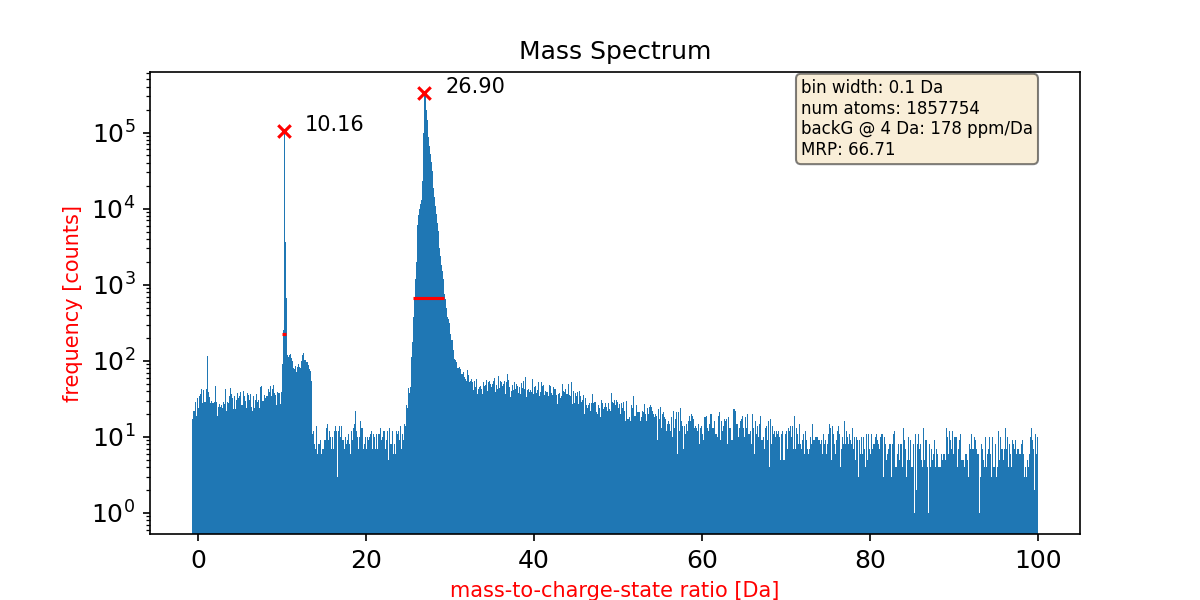

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [66.70708502]
Peaks  0 is: 10.16 peak window sides are: 10.06 - 10.26
Peaks  1 is: 26.90 peak window sides are: 26.80 - 27.20


In [66]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_2[mc_p_2 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='bowl_'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [ ]:
def parametric(input_param, t0, c):
    t = input_param[0]
    delta_t = input_param[1]
    return c * (t - t0)**2 + delta_t

def parametric_calib(dld_t_peak_p, mc_ideal):

    delta_t = interpolate.interp1d(dld_t_peak_p, mc_ideal, kind='linear')
    delta_t_m = delta_t(dld_t_peak_p)  
    delta_t_m = mc_ideal - delta_t_m
    print(delta_t_m)
    fitresult, _ = curve_fit(parametric, [dld_t_peak_p, delta_t_m], mc_ideal)
    return fitresult, delta_t_m

dld_t_peak_p = [78.45, 457.56, 620.28]
mc_ideal = [1, 13.49, 26.98]


fitresult, delta_t_m = parametric_calib(dld_t_peak_p, mc_ideal)


mc_p_3 = parametric([dld_t_peak_p, delta_t_m], *fitresult)

In [ ]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_3[mc_p_3 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='bowl_'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))